# Sistem za preporuku filmova zasnovan na kolaborativnom filtriranju

U ovom delu bavimo se izgradnjom sistema za preporuku koji je zasnovan na kolaborativnom filtriranju (eng. *collaborative filtering*). Ocene filmova se predviđaju na osnovu sličnosti među korisnicima (*user-based collaborative filtering*), odnosno među filmovima (*item-based collaborative filtering*). Preporučuju se oni filmovi za koje je predviđena ocena najviša. Učitajmo i pripremimo najpre neophodne podatke.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from ast import literal_eval
from scipy import sparse as sps
from sklearn.metrics import mean_squared_error
import math
from scipy.sparse.linalg import svds

import warnings; warnings.simplefilter('ignore')

In [2]:
ratings = pd.read_csv('the-movies-dataset/ratings_small.csv',usecols=['userId','movieId','rating'])
ratings.head()

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


## 1. KNN pristup 

Koristićemo algoritam K najbližih suseda. Podaci treba da budu u formi $n x m$ matrice, gde je $m$ broj filmova a $n$ broj korisnika. Primenjujemo funkciju **pivot** na dataFrame *ratings*. Zatim popunjavamo nedostajuće podatke nulama. Tako dobijamo novi dataFrame koji ćemo nazvati *ratings_pivot*.

In [59]:
ratings_pivot = ratings.pivot(index='userId',columns='movieId',values='rating').fillna(0)
ratings_pivot.head(5)

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [60]:
ratings_pivot.shape

(671, 9066)

Matrica *ratings_pivot* je dosta retka, pa ćemo iskoristiti funkciju **csr_matrix** iz **scipy.sparse** paketa.

In [61]:
ratings_matrix = sps.csr_matrix(ratings_pivot)
print(ratings_matrix.todense())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [4. 0. 0. ... 0. 0. 0.]
 [5. 0. 0. ... 0. 0. 0.]]


Delimo podatke na trening i test skup. Matrice treba da budu istih dimenzija, samo ocene drugačije raspodeljene.

In [62]:
def train_test_splitting(ratings_matrix, test_size): # test_size ocena ce biti u skupu za testiranje
    
    ratings = ratings_matrix.toarray()
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    rows = (ratings != 0).sum(1)
    
    for user in range(ratings.shape[0]):
        count_per_user=int(np.ceil(test_size*rows[user]))
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0], # 0 jer je nonzero primenjeno na vektor
                                        size=count_per_user,  # indeksi na kojima nisu 0
                                        replace=False)
        # u trening skup se upisuju 0 na izabranim pozicijama, a u skup za testiranje se upisuju elementi 
        train[user, test_ratings] = 0
        test[user, test_ratings] = ratings[user, test_ratings] 
        
    # provera da li su poznate ocene ili u jednom ili u drugom skupu
    assert(np.all((train * test) == 0)) 
    return sps.csr_matrix(train),sps.csr_matrix(test)

Definišemo funkciju koja računa gustinu popunjenosti matrice. Trening i test skup treba da budu različite gustine, odnosno da imaju 4:1 odnos broja ne-nula elemenata.

In [63]:
def density(ratings): 
    density = float(len(ratings.nonzero()[0]))
    density /= (ratings.shape[0] * ratings.shape[1])
    density *= 100
    return round(density,3)

In [64]:
train, test = train_test_splitting(ratings_matrix, 0.2)
print('Non zero count - train: ',train.getnnz())
print('Density - train: ',density(train),'%')
print('Non zero count - test: ',test.getnnz())
print('Density - test: ',density(test),'%')

Non zero count - train:  79748
Density - train:  1.311 %
Non zero count - test:  20256
Density - test:  0.333 %


Implementiramo KNN algoritam.

In [65]:
def k_nearest_neighbors(i, similarity_matrix, k=10):
   
    neighbors = []
    similarities = list(zip(similarity_matrix[i][:],range(similarity_matrix.shape[0])))
    similarities.sort(key = lambda x: x[0], reverse=True)
    for i in range(1,k+1):
        neighbors.append(similarities[i][1])
    
    return neighbors

### User-based kolaborativno filtriranje
Računamo matricu sličnosti između korisnika. Računamo kosinusno rastojanje.

In [66]:
def similarity_between_users(ratings, epsilon=1e-9):
    return cosine_similarity(ratings) + epsilon 

In [67]:
users_similarity = similarity_between_users(train)
users_similarity.shape

(671, 671)

In [68]:
nearest_neighbors = k_nearest_neighbors(1,users_similarity)
nearest_neighbors

[368, 150, 384, 337, 399, 81, 420, 665, 143, 534]

Previđanje ocene korisnika $u$ za film $i$ na osnovu formule:
$ r'_{ui} = \mu_u + \frac{\sum_{v \in N^k_i(u)}sim(u,v)(r_{vi}-\mu_v)}{\sum_{v \in N^k_i(u)}sim(u,v)} $

In [69]:
def user_based_prediction(u, i, users_similarity, ratings, k):
        
        neighbors = k_nearest_neighbors(u,users_similarity,k)
        mu_u = ratings[u].mean()
        sum1 = 0.0
        sum2 = 0.0
    
        for v in neighbors:            
            mu_v = ratings[v].mean()
            r_vi = ratings[v,i]
            sum1 += users_similarity[u][v]*(r_vi - mu_v)
            sum2 += users_similarity[u][v]
            
    
        return mu_u + sum1/sum2

In [70]:
def get_user_based_prediction(ratings, users_similarity, k = 10):
    predictions = np.zeros(ratings.shape)
    
    for u in range(ratings.shape[0]):
        for i in range(ratings.shape[1]):
            predictions[u,i] = user_based_prediction(u,i,users_similarity,ratings, k)
            
    return predictions
    
    

### Item-based kolaborativno filtriranje
Računamo matricu sličnosti između filmova. Računamo kosinusno rastojanje.

In [71]:
def similarity_between_movies(ratings, epsilon=1e-9):
    return cosine_similarity(ratings.T) + epsilon

In [72]:
movies_similarity = similarity_between_movies(train)
movies_similarity.shape

(9066, 9066)

In [73]:
nearest_neighbors = k_nearest_neighbors(5,movies_similarity)
nearest_neighbors

[615, 31, 644, 263, 561, 24, 535, 529, 20, 344]

Previđanje ocene korisnika $u$ za film $i$ na osnovu formule:
$ r'_{ui} = \mu_i + \frac{\sum_{j \in N^k_u(i)}sim(i,j)(r_{uj}-\mu_j)}{\sum_{j \in N^k_u(i)}sim(i,j)} $

In [74]:
def item_based_prediction(u, i, movies_similarity, ratings, k):
        
        neighbors = k_nearest_neighbors(i,movies_similarity,k)
        mu_i = ratings[:,i].mean()
        sum1 = 0.0
        sum2 = 0.0
    
        for j in neighbors:            
            mu_j = ratings[:,j].mean()
            r_uj = ratings[u,j]
            sum1 += movies_similarity[i][j]*(r_uj - mu_j)
            sum2 += movies_similarity[i][j]
            
    
        return mu_i + sum1/sum2

In [75]:
def get_item_based_prediction(ratings, movies_similarity, k = 10):
    predictions = np.zeros(ratings.shape)
    
    for u in range(ratings.shape[0]):
        for i in range(ratings.shape[1]):

            predictions[u,i] = item_based_prediction(u, i, movies_similarity, ratings, k)
            
    return predictions
    

### Evaluacija

**!!! Zbog predugog vremena izvršavanja i tehničkih problema redukujemo skupove podataka !!! **

In [76]:
ratings_reduced = ratings_matrix[:100,:150] 
ratings_reduced.shape

(100, 150)

In [77]:
train_reduced, test_reduced = train_test_splitting(ratings_reduced, 0.2)
print(train_reduced.shape, test_reduced.shape)

(100, 150) (100, 150)


In [78]:
print('Density - train_reduced: ',density(train_reduced))
print('Non zero count - train: ',train_reduced.getnnz())
print('Density - test_reduced: ',density(test_reduced))
print('Non zero count - test: ',test_reduced.getnnz())

Density - train_reduced:  4.527
Non zero count - train:  679
Density - test_reduced:  1.46
Non zero count - test:  219


In [79]:
users_similarity_reduced = similarity_between_users(train_reduced)
users_similarity_reduced.shape

(100, 100)

In [80]:
movies_similarity_reduced = similarity_between_movies(train_reduced)
movies_similarity_reduced.shape

(150, 150)

In [81]:
ks = [10,15,20,25,30,35,40]

Nalazimo najbolje *k* za user-based KNN, ono kojim se minimizuje RMSE na trening skupu.

In [84]:
errors_train_ub = np.array([])
errors_test_ub = np.array([])

for k in ks:
    predictions = get_user_based_prediction(train_reduced, users_similarity_reduced, k)
    
    error_train = np.sqrt(mean_squared_error(train_reduced.toarray(),predictions))
    error_test = np.sqrt(mean_squared_error(test_reduced.toarray(),predictions))
    
    errors_train_ub = np.append(errors_train_ub, error_train)
    errors_test_ub = np.append(errors_test_ub, error_test)

In [85]:
k_ub_train = ks[errors_train_ub.argmin()]
k_ub_test = ks[errors_test_ub.argmin()]
print('User-based train best k: ',k_ub_train)
print('User-based train RMSE :', errors_train_ub.min())

print('User-based test best k: ',k_ub_test)
print('User-based test RMSE :', errors_test_ub.min())

User-based train best k:  10
User-based train RMSE : 0.6130837736946139
User-based test best k:  40
User-based test RMSE : 0.583331282094667


Primećujemo da se razlikuju optimalne vrednosti parametra $k$ za trening i test skup. Za test skup nam odgovara veća vrednost $k$. Sada nalazimo najbolje *k* za item-based KNN, ono kojim se minimizuje RMSE na trening skupu.

In [87]:
errors_train_ib = np.array([])
errors_test_ib = np.array([])

for k in ks:
    predictions = get_item_based_prediction(train_reduced, movies_similarity_reduced, k)
    
    error_train = np.sqrt(mean_squared_error(train_reduced.toarray(),predictions))
    error_test = np.sqrt(mean_squared_error(test_reduced.toarray(),predictions))
    
    errors_train_ib = np.append(errors_train_ib, error_train)
    errors_test_ib = np.append(errors_test_ib, error_test)

In [88]:
k_ib_train = ks[errors_train_ib.argmin()]
k_ib_test = ks[errors_test_ib.argmin()]
print('Item-based train best k: ',k_ib_train)
print('Item-based train RMSE :', errors_train_ib.min())

print('Item-based test best k: ',k_ib_test)
print('Item-based test RMSE :', errors_test_ib.min())

Item-based train best k:  15
Item-based train RMSE : 0.6170196413405797
Item-based test best k:  40
Item-based test RMSE : 0.5918196548457288


Vizualizacija zavisnosti RMSE od broja suseda *k* na trening skupu.

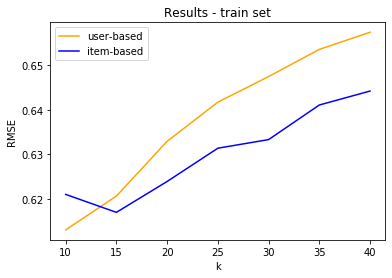

In [89]:
plt.plot(ks, errors_train_ub, color = 'orange', label = 'user-based')
plt.plot(ks, errors_train_ib, color = 'blue', label = 'item-based')
plt.title('Results - train set')
plt.xlabel('k')
plt.ylabel('RMSE')
plt.legend(loc='best')
plt.show()

Vizualizacija zavisnosti RMSE od broja suseda *k* na test skupu.

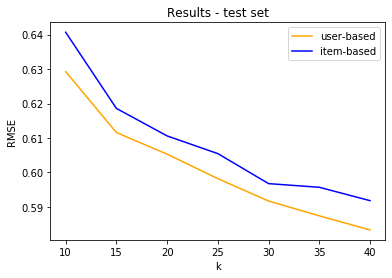

In [90]:
plt.plot(ks, errors_test_ub, color = 'orange', label = 'user-based')
plt.plot(ks, errors_test_ib, color = 'blue', label = 'item-based')
plt.title('Results - test set')
plt.xlabel('k')
plt.ylabel('RMSE')
plt.legend(loc='best')
plt.show()

## 2. Dekompozicija matrica
Još jedan pristup zasnovan na kolaborativnom filtriranju jeste korišćenjem singularne dekompozicije matrica (SVD). Kako je matrica ocena $R$ retka (jedan korisnik je ocenio samo mali deo filmova), ona se može dekomponovati kao $R = M\Sigma U^T$, gde je $U$ matrica korisnika, $M$ matrica filmova, a $\Sigma$ je dijagonalna matrica. Jednostavnosti radi, možemo posmatrati jednakost bez dijagonalne matrice, odnosno samo $R = MU^T$.
Označimo sa $r_{ui}$ ocenu korisnika $u$ za film $i$, sa $p_u$ red matrice $M$ koji se odnosi na korisnika $u$ i sa $q_i$ kolonu matrice $U^T$ koja se odnosi na film $i$. Dobijamo jednakost na osnovu koje se vrši predviđanje ocena: $$ r_{ui}= p_uq_i$$ 

In [91]:
M, sigma, Ut = svds(train, k = 4)

In [92]:
sigma = np.diag(sigma)
sigma

array([[136.46752812,   0.        ,   0.        ,   0.        ],
       [  0.        , 168.88852453,   0.        ,   0.        ],
       [  0.        ,   0.        , 198.21038571,   0.        ],
       [  0.        ,   0.        ,   0.        , 415.29936374]])

In [ ]:
predictions_svd_matrix = np.dot(np.dot(M,sigma),Ut)

In [93]:
train_predictions_svd = list(predictions_svd_matrix[train.nonzero()].flatten())
len(train_predictions_svd)

79748

In [94]:
train_ratings_svd = []
rows,cols = train.nonzero()

for row,col in zip(rows,cols):
    train_ratings_svd.append(train[row,col])

len(train_ratings_svd)

79748

In [95]:
rmse_train_svd = np.sqrt(mean_squared_error(train_ratings_svd,train_predictions_svd))
print('Singular Value Decomposition train RMSE: ',rmse_train_svd)

Singular Value Decomposition train RMSE:  2.956196813823273


In [96]:
test_predictions_svd = list(predictions_svd_matrix[test.nonzero()].flatten())
len(test_predictions_svd)

20256

In [97]:
test_ratings_svd = []
rows,cols = test.nonzero()

for row,col in zip(rows,cols):
    test_ratings_svd.append(test[row,col])

len(test_ratings_svd)

20256

In [99]:
rmse_test_svd = np.sqrt(mean_squared_error(test_ratings_svd,test_predictions_svd))
print('Singular Value Decomposition test RMSE: ',rmse_test_svd)

Singular Value Decomposition test RMSE:  3.049447802265524


## 3. Metod latentnih faktora

Singularna dekompozicije (SVD) matrice ocena može biti skupa jer je matrica retka. Takođe, SVD ne radi kada podaci nedostaju. To umanjuje performanse. Sledeći pristup predviđanja ocena će se sastojati u pronalaženju ovih fakora tako da se minimizuje regularizovana kvadratna greška na trening skupu: $$min_{q^*,p^*,b^*} \sum_{(u,i) \in s} (r_{ui} - q^T_ip_u)^2 + \lambda(||q_i||^2 + ||p_u||^2)$$

Ovo radimo koristeći stohastički gradijentni spust. Najpre inicijalizujemo tražene matrice nasumičnim vrednostima iz unifomne raspodele. Zatim za svaki par (korisnik-film, ocena) iz trening skupa ažuriramo parametre prema grešci između stvarne i predviđene ocene. Na primer, faktor korisnika $p_u$ se ažurira na sledeći način:
$$ p_u = p_u + \alpha*((r_{ui} - r'_{ui})q_i - \lambda p_u)$$

Jednakost na osnovu koje se vrši predviđanje ocena: $$ r_{ui}= p_uq_i$$ 

In [104]:
# RMSE za SGD
def RMSE(data, Q, P):
    I = data != 0  # indikatorska funkcija o ocenjenim filmovima
    ME = I * (data - np.dot(P, Q.T))  # greska izmedju stvarnih i predvidjenih vrednosti
    MSE = ME**2  
    return np.sqrt(np.sum(MSE)/np.sum(I)) 

In [105]:
def stohastic_gradient_descent(train, test, f, number_of_epochs, l, alpha):
    
    users,items = train.nonzero()    
    P = np.random.rand(train.shape[0], f) # latentni faktori za korisnike
    Q = np.random.rand(train.shape[1], f) # latentni faktori za filmove
    
    train_errors = []
    test_errors = []
    
    for epoch in range(number_of_epochs):
        for u, i in zip(users, items):
            diff = train[u, i] - np.dot(P[u,:], Q[i,:].T) # razlika izmedju prave i predvidjene vrednosti
            # azuriranje faktora za korisnike
            P[u, :] += alpha * (diff * Q[i,:] - l * P[u,:])
            #azuriranje faktora za filmove
            Q[i, :] += alpha * (diff * P[u,:] - l * Q[i, :])
        train_errors.append(RMSE(train.toarray(),Q,P))
        test_errors.append(RMSE(test.toarray(),Q,P))
    
    return train_errors, test_errors


Najpre pronadjimo optimalnan broj latentnih faktora, tj. onaj koji minimizuje RMSE na trening skupu. Ostali parametri (regularizacioni parametar $\lambda$ i brzina učenja $\alpha$) za sad su fiksirani.

In [131]:
number_of_epochs = 10
l = 0.5 # regularizacioni parametar 
alpha = 0.01 # brzina učenja
fs = [2*i for i in range(1,10)]
train_rmse = np.array([])

for f in fs:
    train_errors, test_errors = stohastic_gradient_descent(train_reduced, test_reduced, f, number_of_epochs, l, alpha)
    train_rmse = np.append(train_rmse,train_errors[-1])


In [132]:
best_f = fs[train_rmse.argmin()]
print('Najbolji broj latentnih faktora: ', best_f)

Najbolji broj latentnih faktora:  18


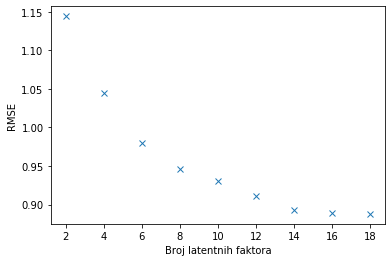

In [133]:
plt.plot(fs,train_rmse,'x')
plt.xlabel('Broj latentnih faktora')
plt.ylabel('RMSE')
plt.show()

Sada postavljamo broj latentnih faktora na 18 i tražimo najbolji regularizacioni parametar $\lambda$.

In [136]:
alpha = 0.01 # brzina učenja
train_rmse = np.array([])
lambdas = [i*0.01 for i in np.linspace(1,50,15)]
for l in lambdas:
    train_errors, test_errors = stohastic_gradient_descent(train_reduced, test_reduced, best_f, number_of_epochs, l, alpha)
    train_rmse = np.append(train_rmse,train_errors[-1])


In [137]:
best_l = lambdas[train_rmse.argmin()]
print('Najbolji regularizacioni parametar: ', best_l)

Najbolji regularizacioni parametar:  0.01


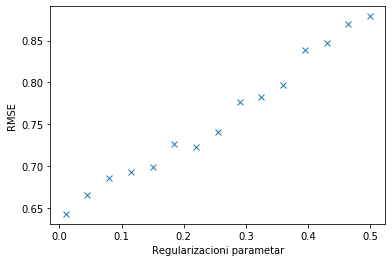

In [138]:
plt.plot(lambdas,train_rmse,'x')
plt.xlabel('Regularizacioni parametar')
plt.ylabel('RMSE')
plt.show()

Sada fiksiramo i $\lambda$ na 0.01. Najzad, nalazimo najbolju brzinu učenja (*learning rate*).

In [153]:
alphas = [0.001*i for i in np.linspace(1,10,10)]
train_rmse = np.array([])

for alpha in alphas:
    train_errors, test_errors = stohastic_gradient_descent(train_reduced, test_reduced, best_f, number_of_epochs, best_l, alpha)
    train_rmse = np.append(train_rmse,train_errors[-1])


In [154]:
best_alpha = alphas[train_rmse.argmin()]
print('Najbolja brzina ucenja: ', best_alpha)

Najbolja brzina ucenja:  0.009000000000000001


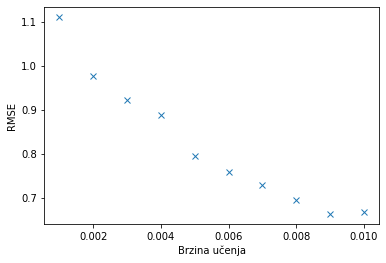

In [155]:
plt.plot(alphas,train_rmse,'x')
plt.xlabel('Brzina učenja')
plt.ylabel('RMSE')
plt.show()

Pogledajmo kako se smanjuje RMSE u zavisnosti od broja epoha, sa pronađenim optimalnim parametrima.

In [161]:
train_errors, test_errors = stohastic_gradient_descent(train_reduced, test_reduced, best_f, number_of_epochs, best_l, best_alpha)

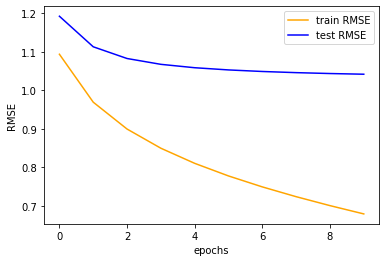

In [162]:
plt.plot(train_errors, color="orange", label='train RMSE')
plt.plot(test_errors, color="blue", label='test RMSE')
plt.xlabel('epochs')
plt.ylabel('RMSE')
plt.legend(loc = 'best')
plt.show()